In [1]:
# %pip install fredapi

In [2]:
# Import python libraries

import datetime
import pandas as pd
import numpy as np
import urllib
import json
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patheffects as PathEffects
from fredapi import Fred

In [3]:
# Load 30-Year Fixed Rate Mortgage Average in the United States (MORTGAGE30US) data

FRED_API_KEY = 'a0c5a1563e276ca035a52f2889606a29'
fred = Fred(api_key=FRED_API_KEY)
data = fred.get_series('MORTGAGE30US')
MORTGAGE30US = pd.DataFrame()
MORTGAGE30US['DATE'] = data.keys()
MORTGAGE30US['MORTGAGE30US'] = data.values
MORTGAGE30US['date'] = ['%i/%i/%02d' % (t.month, t.day, t.year-2000) if t.year >= 2000
                        else '%s/%s/%02d' % (t.month, t.day, t.year-1900) for t in MORTGAGE30US['DATE']]
MORTGAGE30US.tail(3)

,DATE,MORTGAGE30US,date
2671,2022-06-09,5.23,6/9/22
2672,2022-06-16,5.78,6/16/22
2673,2022-06-23,5.81,6/23/22


In [4]:
# Load BTCUSD Daily Close Exchange Rate data

GLASSNODE_API_KEY = '23OAFHpTldWazrv8CDCkqJH3A8G'
url = 'https://api.glassnode.com/v1/metrics/market/price_usd_close'
data = []
label = url.split('/')[-1]
res = requests.get(url, params={'a': 'BTC', 'api_key': GLASSNODE_API_KEY})
price_usd_close_df = pd.read_json(res.text, convert_dates=['t'])
price_usd_close_df.rename(columns={'t': 'date', 'v': label}, inplace=True)
price_usd_close_df['date'] = ['%i/%i/%02d' % (t.month, t.day, t.year-2000) for t in price_usd_close_df['date']]
price_usd_close_df.tail(3)

,date,price_usd_close
4364,6/28/22,20281.265090
4365,6/29/22,20089.318691
4366,6/30/22,19079.558811


In [5]:
# Merge data frames on date and calculate total loan cost over 30-year period

merged_df = pd.merge(price_usd_close_df.iloc[price_usd_close_df[price_usd_close_df['date'] == '11/1/19'].index[0]:],
                     MORTGAGE30US, how='inner', on='date')
merged_df = merged_df[['date', 'price_usd_close', 'MORTGAGE30US']]

fee = 0.03 # closing fee 3%
t = 30 # 30-year term
n = 12 # 12 months per year

merged_df['loan_total_cost'] = [fee + ((r/100/n)*(1+r/100/n)**(n*t))/((1+r/100/n)**(n*t)-1)*n*t for r in
                                merged_df['MORTGAGE30US']]
merged_df['end_date'] = ['%s/%s/%i' % (d.split('/')[0], d.split('/')[1], int(d.split('/')[2])+30)
                         for d in merged_df['date']]
merged_df['break_even_price'] = [merged_df['price_usd_close'].iloc[i]*merged_df['loan_total_cost'].iloc[i]
                                 for i in range(len(merged_df))]
orig_dates = merged_df['date']
merged_df.tail(3)

,date,price_usd_close,MORTGAGE30US,loan_total_cost,end_date,break_even_price
135,6/9/22,30112.468524,5.23,2.013476,6/9/52,60630.737071
136,6/16/22,20368.602765,5.78,2.137728,6/16/52,43542.535205
137,6/23/22,21080.309850,5.81,2.144604,6/23/52,45208.916928


In [6]:
# functions used to make plotting datetime data easier

def str_to_datetime(strs):
    """Convert a list of "YYYY-MM-DD" strings to datetime objects."""
    dates = []
    for date in strs:
        if '-' in date:
            y, m, d = (int(x) for x in date.split("-"))
        elif '/' in date:
            m, d, y = int(date.split('/')[0]), int(date.split('/')[1]), \
            int(date.split('/')[2])+2000
        date = datetime.datetime(y, m, d)
        dates.append(date)
    return dates

datetimes = str_to_datetime(orig_dates)
dates = [mdates.date2num(date) for date in datetimes]

def x_axis_dates(ax=None, fig=None):
    """Helper function to format the x axis as dates.

    Input:
    ax:  An Axes instance or an iterable of Axes instances.
    Optional, defaults to plt.gca()
    fig: The Figure instance containing those Axes or Axeses
    Optional, defaults to plt.gcf()
    """
    if ax is None: ax = plt.gca()
    if fig is None: fig = plt.gcf()
    loc = mdates.AutoDateLocator()
    fmt = mdates.AutoDateFormatter(loc)
    try:
        ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_major_formatter(fmt)
    except AttributeError:
        for a in ax:
            # Fresh locators/formatters are needed for each instance
            loc = mdates.AutoDateLocator()
            fmt = mdates.AutoDateFormatter(loc)
            a.xaxis.set_major_locator(loc)
            a.xaxis.set_major_formatter(fmt)
    fig.autofmt_xdate()

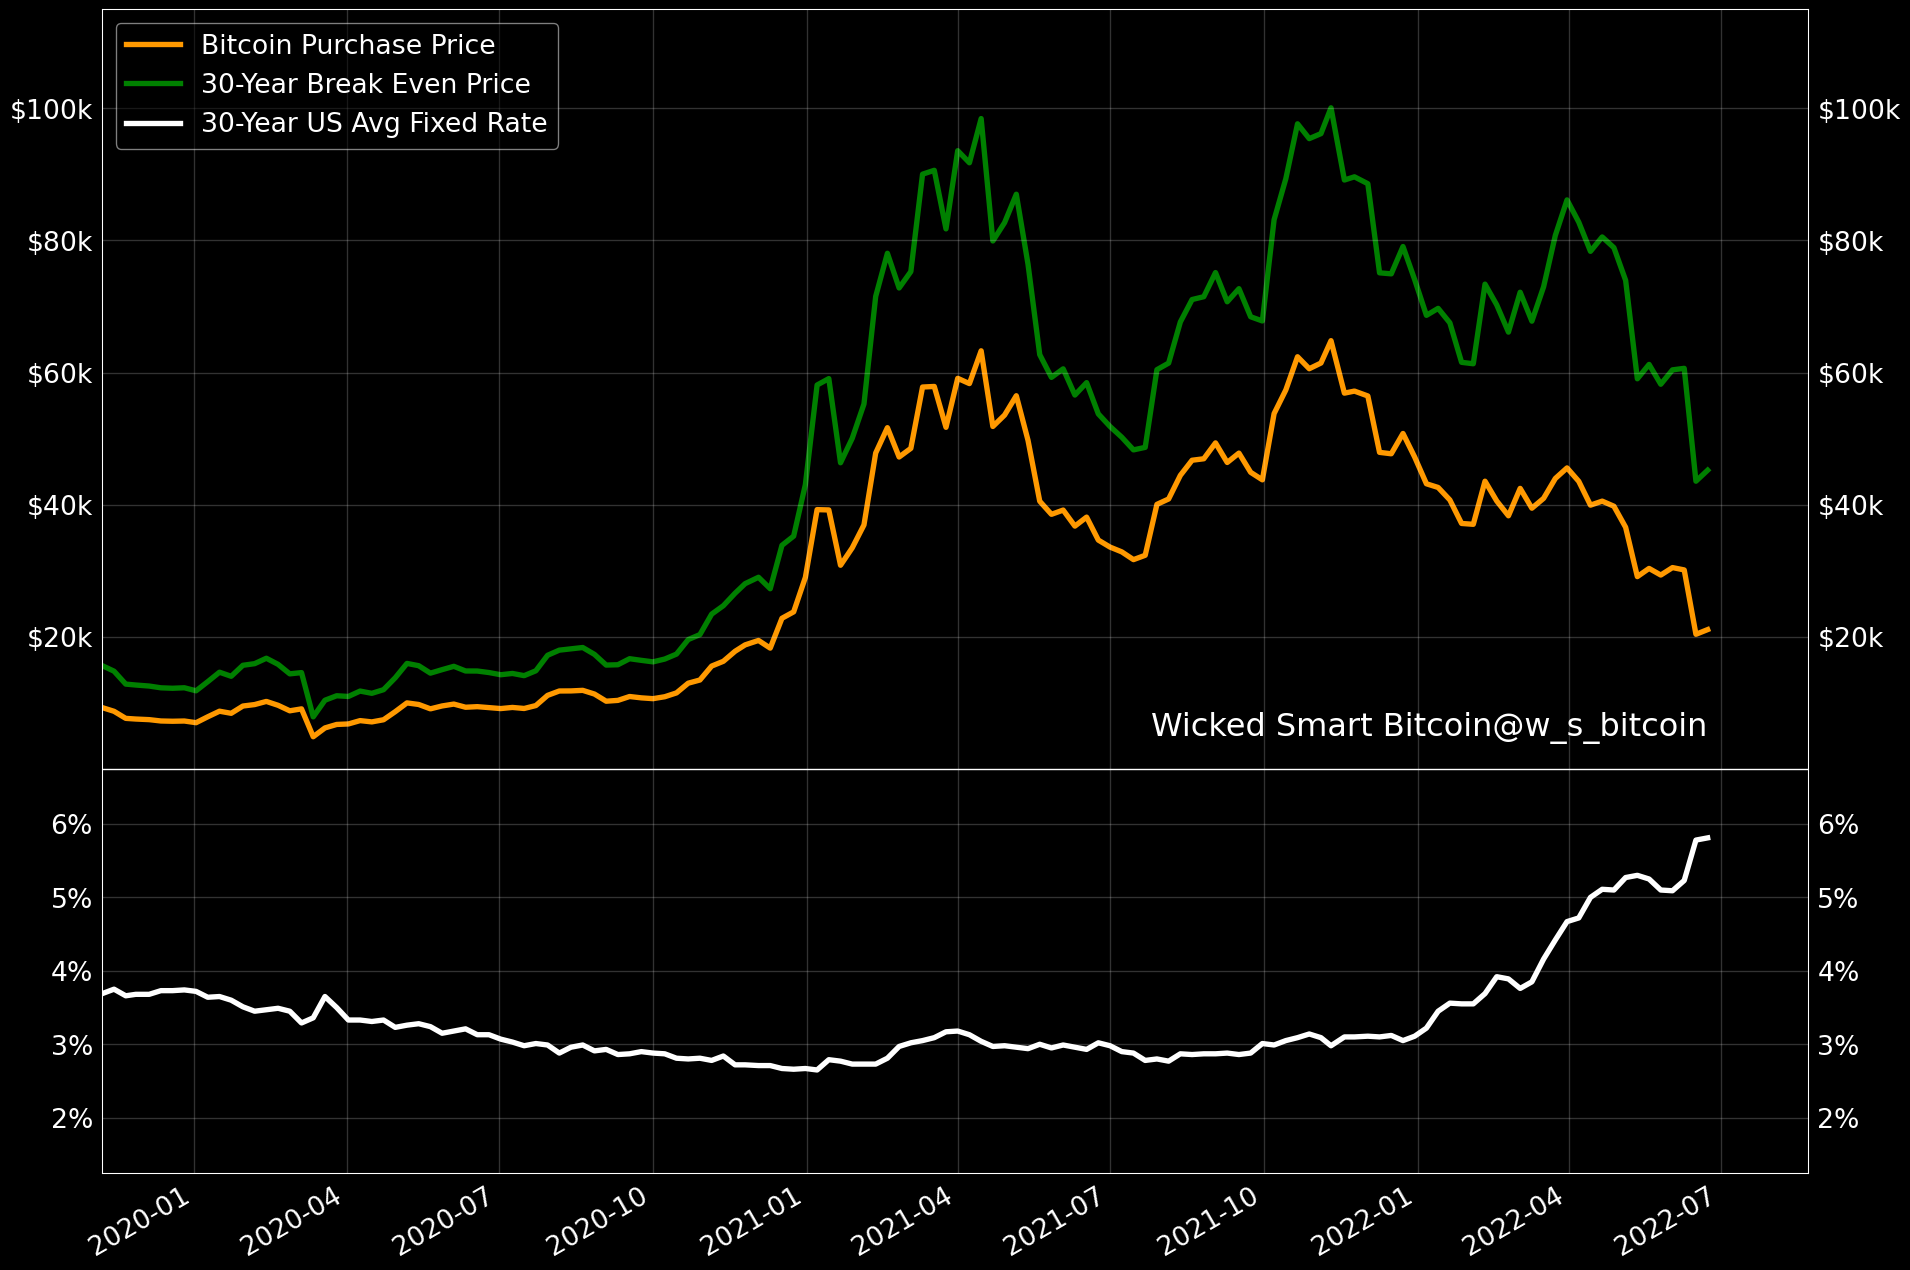

In [7]:
# plots

res = (1920, 1280)
size = res[0]/96.
size_y = res[1]/96.

cmap = cm.get_cmap('Spectral_r', 100)
min_c = merged_df['MORTGAGE30US'].min()
max_c = merged_df['MORTGAGE30US'].max()

darkmode = True

# create figure and axis objects with subplots()
if darkmode:
    bgc = 'black'
    lnc = 'white'
else:
    bgc = 'white'
    lnc = 'black'

fig, (ax) = plt.subplots(1, 1, figsize=(size, size_y), dpi=96, facecolor=bgc)
ax.set_facecolor(bgc)
for spine in ax.spines.values():
    spine.set_edgecolor(lnc)

plt.rc('axes', axisbelow=True)

orig_price_dates = merged_df['date']
price_datetimes = str_to_datetime(orig_price_dates)
price_dates = [mdates.date2num(dt) for dt in price_datetimes]
prices = merged_df['break_even_price']

max_price = max(prices)
max_mortgage = 6.75
# for i in range(len(merged_df)):
#     plt.fill_between(price_dates[i:i+2], merged_df['price_usd_close'].iloc[i:i+2],
#                      merged_df['break_even_price'].iloc[i:i+2],
#                      color=cmap((merged_df['MORTGAGE30US'].iloc[i]-min_c)/(max_c-min_c)))
#     plt.plot(price_dates[i:i+2], [r*0.75*max_price/(max_mortgage)-0.75*max_price for r in
#                                   merged_df['MORTGAGE30US'].iloc[i:i+2]],
#              color=lnc, linewidth=4, zorder=1)
#     plt.plot(price_dates[i:i+2], [r*0.75*max_price/(max_mortgage)-0.75*max_price for r in
#                                   merged_df['MORTGAGE30US'].iloc[i:i+2]],
#              color=cmap((merged_df['MORTGAGE30US'].iloc[i]-min_c)/(max_c-min_c)), linewidth=3, zorder=2)
plt.plot(price_dates, [r*0.75*max_price/(max_mortgage)-0.75*max_price for r in merged_df['MORTGAGE30US']],
         color=lnc, linewidth=4, zorder=1, label='30-Year US Avg Fixed Rate')
plt.plot(price_dates, prices, color='green', linewidth=4, zorder=1, label='30-Year Break Even Price')
plt.plot(price_dates, merged_df['price_usd_close'], color='#ff9900', linewidth=4, zorder=1,
         label='Bitcoin Purchase Price')
plt.plot([price_dates[0], max(price_dates)+60], [0, 0], color=lnc, zorder=3, linewidth=1)
plt.xlim(min(price_dates), max(price_dates)+60)
plt.ylim(1.25*0.75*max_price/(max_mortgage)-0.75*max_price, 115000)
plt.yticks([r*0.75*max_price/(max_mortgage)-0.75*max_price for r in [2, 3, 4, 5, 6]] +
           [0, 20000, 40000, 60000, 80000, 100000],
           ['2%', '3%', '4%', '5%', '6%', '', '$20k', '$40k', '$60k', '$80k', '$100k'],
           fontsize=20, color=lnc)
plt.xticks(fontsize=20, color=lnc)

# plt.plot([price_dates[merged_df['MORTGAGE30US'][merged_df['date'] == '10/15/20'].index[0]],
#           price_dates[merged_df['MORTGAGE30US'][merged_df['date'] == '10/15/20'].index[0]]],
#          [merged_df['MORTGAGE30US'][merged_df['date'] == '10/15/20'].iloc[0]*0.75*max_price/
#           max_mortgage-0.75*max_price, merged_df['break_even_price'][merged_df['date'] == '10/15/20'].iloc[0]],
#          color='#c8c8c8', linestyle='--', linewidth=3)

# plt.scatter([price_dates[merged_df['MORTGAGE30US'][merged_df['date'] == '10/15/20'].index[0]]],
#             [merged_df['MORTGAGE30US'][merged_df['date'] == '10/15/20'].iloc[0]*0.75*max_price/
#             max_mortgage-0.75*max_price], color='#c8c8c8', s=5, zorder=5)
# plt.scatter([price_dates[merged_df['MORTGAGE30US'][merged_df['date'] == '10/15/20'].index[0]]],
#             [merged_df['price_usd_close'][merged_df['date'] == '10/15/20'].iloc[0]], color='#c8c8c8', s=5,
#             zorder=5)
# plt.scatter([price_dates[merged_df['MORTGAGE30US'][merged_df['date'] == '10/15/20'].index[0]]],
#             [merged_df['break_even_price'][merged_df['date'] == '10/15/20'].iloc[0]], color='#c8c8c8', s=5,
#             zorder=5)

# txt = plt.text(min(x)+0.9825*(max(x)-min(x)), 2000, 'Wicked Smart Bitcoin@w_s_bitcoin',
#                fontsize=32, horizontalalignment='right', color='white')
plt.grid(color=lnc, lw=1, linestyle='-', alpha=0.2)
ax.tick_params(labelright=True)

# plt.title('30-Year Fixed Rate Cash-Out Refi & Bitcoin Lump Sum Analysis', color=lnc, fontsize=30, pad=20)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1], labels[::-1], loc='upper left', facecolor=bgc, framealpha=0.5,
                   fontsize=20)
for text in legend.get_texts():
    text.set_color(lnc)
frame = legend.get_frame()
frame.set_edgecolor(lnc)


txt = plt.text(min(price_dates)+1*(max(price_dates)-min(price_dates)), 5000,
               'Wicked Smart Bitcoin@w_s_bitcoin', fontsize=24, horizontalalignment='right', color=lnc)

x_axis_dates()
plt.tight_layout()

# fig.savefig('bitcoin-fear-and-greed.png')

In [8]:
# Checking important dates (when Saylor mentioned this strategy)

# price_usd_close_df[price_usd_close_df['date'] == '10/13/20']
# merged_df[merged_df['date'] == '10/15/20']
merged_df[merged_df['date'] == '3/11/21']

,date,price_usd_close,MORTGAGE30US,loan_total_cost,end_date,break_even_price
70,3/11/21,57800.366714,3.05,1.5575,3/11/51,90024.047195


In [9]:
# price_usd_close_df[price_usd_close_df['date'] == '3/10/21']
price_usd_close_df.iloc[-1]

date                    6/30/22
price_usd_close    19079.558811
Name: 4366, dtype: object

In [11]:
P = 19079.56
r = 0.0581
n = 12
t = 30
monthly_cost = (P*(r/n)*(1+r/n)**(n*t))/((1+r/n)**(n*t)-1)
total_cost = monthly_cost*12*30
print(monthly_cost)
print(total_cost)

112.07142774395625
40345.71398782425
